In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

tf.keras.backend.set_floatx('float32')
plt.rcParams.update({
    "text.usetex":True,
    "font.family":"serif",
}) # enable tex rendering in matplotlib

In [3]:
colab_flag = False

FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/new_ks


In [7]:
from tools.misc_tools import mytimecallback, SaveLosses, plot_losses, readAndReturnLossHistories, plot_reconstructed_data_KS, plot_latent_states_KS
from tools.ae_v1 import Autoencoder

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [10]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 0
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2023-06-28 15:07:07.526365: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-28 15:07:07.526837: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-28 15:07:07.600750: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-28 15:07:07.601093: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-28 15:07:07.601369: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [11]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
2.8.1


# KS System

In [12]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # loading data directory
    data_dir_idx = '000'

    # making ae save directory
    dir_name_ae = os.getcwd() + dir_sep + 'saved_ae'
    if not os.path.isdir(dir_name_ae):
        os.makedirs(dir_name_ae)

    counter = 0
    while True:
        dir_check = 'ae_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_ae + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_ae = dir_name_ae + dir_sep + dir_check
    os.makedirs(dir_name_ae)
    os.makedirs(dir_name_ae+dir_sep+'plots')
else:
    # some paramaters
    dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_015'.format(ds=dir_sep)

    with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
        lines = f.readlines()

    params_dict = eval(''.join(lines))
    data_dir_idx = params_dict['data_dir_idx']
    normalizeforae_flag = params_dict['normalizeforae_flag']
    normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
    if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
        with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
            normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]

print('dir_name_ae:', dir_name_ae)
# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state = params_dict['init_state']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
numpoints_xgrid = params_dict['numpoints_xgrid']
length = params_dict['length']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

xgrid = length*np.linspace(0, 1, numpoints_xgrid)

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data'].astype(FTYPE)
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']

    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']

dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae/ae_014
normalize_flag_ogdata: False


In [13]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.06465670311438651, lyapunov time : 15.466300964355469s


In [14]:
positve_lp_idx = np.where(lyapunov_time_arr > 0)[0]
print(positve_lp_idx)

[0]


In [15]:
last_idx = all_data.shape[0]
temp_bia = np.zeros(shape=1+boundary_idx_arr.shape[0], dtype=np.int32)
temp_bia[1:] = boundary_idx_arr
print(temp_bia)
for i in range(boundary_idx_arr.shape[0]-1, -1, -1):
    if not (i in positve_lp_idx):
        print(i)
        num_idxs = last_idx - temp_bia[i+1]
        all_data[temp_bia[i]:temp_bia[i]+num_idxs] = all_data[temp_bia[i+1]:last_idx]
        last_idx = last_idx - (temp_bia[i+1]-temp_bia[i])

[     0 500026]


In [16]:
new_bia = np.empty_like(boundary_idx_arr)
new_bia[:] = boundary_idx_arr
new_pmat = np.empty_like(params_mat)
new_pmat[:, :] = params_mat
counter = 0
bia_counter = boundary_idx_arr.shape[0]
for i in range(boundary_idx_arr.shape[0]):
    if not (i in positve_lp_idx):
        new_bia[i:] -= temp_bia[i+1] - temp_bia[i]
        new_bia[i:bia_counter-1] = new_bia[i+1:bia_counter]
        new_pmat[i:bia_counter-1] = new_pmat[i+1:bia_counter]
        bia_counter -= 1

In [17]:
new_bia = new_bia[0:bia_counter]
new_pmat = new_pmat[0:bia_counter]

In [18]:
all_data = all_data[0:new_bia[-1]]

In [19]:
new_bia, boundary_idx_arr = boundary_idx_arr, new_bia
new_pmat, params_mat = params_mat, new_pmat

In [20]:
# dealing with normalizing the data before feeding into autoencoder
if behaviour == 'initialiseAndTrainFromScratch':
    # normalize data before feeding into autoencoder?
    normalizeforae_flag = True
    normalization_type = 'stddev' # could be 'stddev' or 'minmax'
    stddev_multiplier = 3
    stddev_multiplier_pm = 1
    num_params = params_mat.shape[1]

    ae_data_with_params = False # whether to feed in the parameters to the AE along with the data?

    og_vars = all_data.shape[1]
    if alldata_withparams_flag == True:
        og_vars -= num_params

    if ae_data_with_params == False:
        stddev_multiplier_pm = None
    if normalizeforae_flag == False:
        stddev_multiplier = None

    if ae_data_with_params == True and alldata_withparams_flag == False:
        new_all_data = np.empty(shape=(all_data.shape[0], og_vars+num_params), dtype=FTYPE)
        new_all_data[:, 0:og_vars] = all_data[:, 0:og_vars]
        del(all_data)
        all_data = new_all_data
        prev_idx = 0
        for i in range(boundary_idx_arr.shape[0]):
            all_data[prev_idx:boundary_idx_arr[i], num_params:] = params_mat[i]
            prev_idx = boundary_idx_arr[i]

    normalization_constant_arr_aedata = None
    if normalizeforae_flag == True:
        normalization_constant_arr_aedata = np.empty(shape=(2, all_data.shape[1]), dtype=FTYPE)
        if normalization_type == 'stddev':
            sample_mean = np.mean(all_data, axis=0)
            sample_std = np.std(all_data, axis=0)
            normalization_constant_arr_aedata[0, :] = sample_mean
            normalization_constant_arr_aedata[1, 0:og_vars] = stddev_multiplier*sample_std[0:og_vars]
            if ae_data_with_params == True:
                normalization_constant_arr_aedata[1, og_vars:] = stddev_multiplier_pm*sample_std[og_vars:]
            zero_idx = np.where(normalization_constant_arr_aedata[1] == 0.0)[0]
            if len(zero_idx) > 0:
                normalization_constant_arr_aedata[1, zero_idx] = 1.0
        elif normalization_type == 'minmax':
            for i in range(all_data.shape[1]):
                sample_min = np.min(all_data[:, i])
                sample_max = np.max(all_data[:, i])
                if sample_max - sample_min == 0:
                    sample_min = sample_min - 0.5
                    sample_max = sample_min + 1
                normalization_constant_arr_aedata[0, i] = sample_min
                normalization_constant_arr_aedata[1, i] = sample_max - sample_min
        # if ae_data_with_params == True:
        #     normalization_constant_arr_aedata[0, og_vars:] = 0.0
        #     normalization_constant_arr_aedata[1, og_vars:] = 1.0
        for i in range(all_data.shape[1]):
            all_data[:, i] -= normalization_constant_arr_aedata[0, i]
            all_data[:, i] /= normalization_constant_arr_aedata[1, i]

    # saving sim data
    ae_data = {
        'data_dir_idx':data_dir_idx,
        'normalizeforae_flag':normalizeforae_flag,
        'normalization_constant_arr_aedata':normalization_constant_arr_aedata,
        'normalization_type':normalization_type,
        'stddev_multiplier':stddev_multiplier,
        'stddev_multiplier_pm':stddev_multiplier_pm,
        'ae_data_with_params':ae_data_with_params,
        'module':Autoencoder.__module__,
    }
    with open(dir_name_ae+dir_sep+'ae_data.txt', 'w') as f:
        f.write(str(ae_data))
    np.savez(
        dir_name_ae+dir_sep+'normalization_data',
        normalization_constant_arr_aedata=[normalization_constant_arr_aedata],
    )
else:
    if normalizeforae_flag == True:
        for i in range(all_data.shape[1]):
            all_data[:, i] -= normalization_constant_arr_aedata[0, i]
            all_data[:, i] /= normalization_constant_arr_aedata[1, i]
            
time_stddev = np.std(all_data, axis=0)
if ae_data_with_params == False:
    all_data = all_data[:, 0:og_vars]
    time_stddev = time_stddev[0:og_vars]
else:
    time_stddev[og_vars:] = 1.0

In [21]:
normalization_constant_arr_aedata

array([[ 1.04895428e-01,  1.00677975e-01,  1.01455748e-01,
         1.07038975e-01,  1.15524963e-01,  1.24498643e-01,
         1.32090986e-01,  1.37528211e-01,  1.41156599e-01,
         1.44102126e-01,  1.47524297e-01,  1.51665181e-01,
         1.54968590e-01,  1.54004678e-01,  1.45411506e-01,
         1.28925756e-01,  1.08675964e-01,  9.11559835e-02,
         8.14666823e-02,  8.09827968e-02,  8.77058581e-02,
         9.81689095e-02,  1.08952150e-01,  1.17303252e-01,
         1.21563986e-01,  1.21806026e-01,  1.19666912e-01,
         1.17023595e-01,  1.14840910e-01,  1.13341480e-01,
         1.12681627e-01,  1.12990953e-01,  1.14061654e-01,
         1.15491308e-01,  1.17183998e-01,  1.19535834e-01,
         1.23133965e-01,  1.28426880e-01,  1.35574624e-01,
         1.44235477e-01,  1.52901426e-01,  1.58540055e-01,
         1.57794520e-01,  1.49408311e-01,  1.35650888e-01,
         1.21296138e-01,  1.11013673e-01,  1.07349895e-01,
         1.10332102e-01,  1.18103951e-01,  1.27738327e-0

# Autoencoder

In [22]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [1e-3, 1e-4, 1e-5]
    epochs = 200
    patience = 10  # parameter for early stopping
    min_delta = 1e-6  # parameter for early stopping
    lambda_reg = 1.00542493e-07 # weight for regularizer
    train_split = 0.8
    val_split = 0.1
    test_split = 1 - train_split - val_split
    batch_size = 2**6
    fRMS = 1.07498237e-03
    ls_fRMS = 1e-3
    timeMeanofSpaceRMS = np.mean(np.mean(all_data[:, 0:og_vars]**2, axis=1)**0.5)
    
    dt_ae = 0.2
    
    # stddev = fRMS*timeMeanofSpaceRMS
    stddev = fRMS * np.mean(time_stddev[0:og_vars])
    ls_stddev = ls_fRMS * 0.2
    contractive_lmda = 0.0 # 0.0010001779435464704
    use_weights_post_dense = True
    dropout_rate = 0.0
    
    print('stddev : ', stddev)
    print('ls_stddev : ', ls_stddev)

    # saving training params
    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS,
        'ls_fRMS':ls_fRMS,
        'timeMeanofSpaceRMS':timeMeanofSpaceRMS,
        'stddev':stddev,
        'ls_stddev':ls_stddev,
        'contractive_lmda':contractive_lmda,
        'dropout_rate':dropout_rate,
        'dt_ae':dt_ae,
    }

    with open(dir_name_ae+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
else:
    with open(dir_name_ae + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    learning_rate_list = tparams_dict['learning_rate_list']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    try:
        stddev = tparams_dict['stddev']
    except:
        print("'stddev' not in tparams_dict, set to 0")
        stddev = 0.0
    try:
        ls_stddev = tparams_dict['ls_stddev']
    except:
        print("'ls_stddev' not in tparams_dict, set to 0")
        ls_stddev = 0.0
    try:
        contractive_lmda = tparams_dict['contractive_lmda']
    except:
        print("'contractive_lmda' not in tparams_dict, set to 0")
        contractive_lmda = 0.0
    try:
        dropout_rate = tparams_dict['dropout_rate']
    except:
        print("'dropout_rate' not in tparams_dict, set to 0")
        dropout_rate = 0.0

    test_split = 1 - train_split - val_split

    # setting seed for PRNGs
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

stddev :  0.0003583286206766185
ls_stddev :  0.0002


In [23]:
# all_data = all_data[0:370001]
# boundary_idx_arr[0] = 370001

In [24]:
skip_factor = int(dt_ae/delta_t)

for i in range(len(boundary_idx_arr)-1, -1, -1):
    end_idx = boundary_idx_arr[i]
    if i == 0:
        begin_idx = 0
    else:
        begin_idx = boundary_idx_arr[i-1]

    num_elems_pre_indexing = end_idx - begin_idx
    num_elems_post_indexing = (num_elems_pre_indexing+skip_factor-1)//skip_factor

    boundary_idx_arr[i:] -= num_elems_pre_indexing-num_elems_post_indexing

    all_data[begin_idx:begin_idx+num_elems_post_indexing] = all_data[begin_idx:end_idx:skip_factor]
    all_data[begin_idx+num_elems_post_indexing:begin_idx+(boundary_idx_arr[-1]-boundary_idx_arr[i])] = all_data[end_idx:boundary_idx_arr[-1]+num_elems_post_indexing]

all_data = all_data[0:boundary_idx_arr[-1]]

In [25]:
boundary_idx_arr

array([250013])

In [26]:
all_data.shape

(250013, 64)

In [27]:
# # setting up data
# idx = np.arange(all_data.shape[0])
# np.random.shuffle(idx)
# boundary = int(np.round((1-test_split)*all_data.shape[0]))
# training_data = all_data[idx[0:boundary], :]
# testing_data = all_data[idx[boundary:], :]

In [28]:
cum_samples = boundary_idx_arr[-1]
# idx = np.arange(cum_samples)
# np.random.shuffle(idx)
num_train = 0
num_val = 0
begin_idx = 0
for i in range(len(boundary_idx_arr)):
    num_samples = boundary_idx_arr[i] - begin_idx
    num_train += int( np.round(train_split*num_samples) )
    num_val += int( np.round(val_split*num_samples) )
    begin_idx = boundary_idx_arr[i]

# defining shapes
training_shape = [num_train]
training_shape.extend(all_data.shape[1:])

val_shape = [num_val]
val_shape.extend(all_data.shape[1:])

testing_shape = [cum_samples-num_train-num_val]
testing_shape.extend(all_data.shape[1:])

# defining required arrays
training_data = np.empty(shape=training_shape)

val_data = np.empty(shape=val_shape)

testing_data = np.empty(shape=testing_shape)

begin_idx = 0
training_data_rolling_count = 0
val_data_rolling_count = 0
testing_data_rolling_count = 0
for i in range(len(boundary_idx_arr)):
    num_samples = boundary_idx_arr[i] - begin_idx
    num_train = int( np.round(train_split*num_samples) )
    num_val = int( np.round(val_split*num_samples) )

    training_data[training_data_rolling_count:training_data_rolling_count+num_train] = all_data[begin_idx:begin_idx+num_train]
    training_data_rolling_count += num_train

    val_data[val_data_rolling_count:val_data_rolling_count+num_val] = all_data[begin_idx+num_train:begin_idx+num_train+num_val]
    val_data_rolling_count += num_val

    num_test = num_samples-num_train-num_val
    testing_data[testing_data_rolling_count:testing_data_rolling_count+num_test] = all_data[begin_idx+num_train+num_val:begin_idx+num_train+num_val+num_test]
    testing_data_rolling_count += num_test

    begin_idx = boundary_idx_arr[i]

# further shuffling
# idx = np.arange(0, training_data.shape[0])
# np.random.shuffle(idx)
# training_data_rnn_input = training_data_rnn_input[idx]
np.random.shuffle(training_data)

# idx = np.arange(0, val_data.shape[0])
# np.random.shuffle(idx)
# val_data = val_data[idx]
np.random.shuffle(val_data)

# idx = np.arange(0, testing_data.shape[0])
# np.random.shuffle(idx)
# testing_data = testing_data[idx]
np.random.shuffle(testing_data)

In [29]:
#

In [30]:
# Initialize network
if behaviour == 'initialiseAndTrainFromScratch':
    latent_space_dim = 16
    enc_layers = [128, 96, 64, 48, 32, 24, 16, 8, 4]
    # enc_layers = [192, 96, 48, 24, 12, 6, 3]
    # enc_layers = [96, 48, 24, 12, 6, 3]
    # enc_layers = [128, 64, 32, 16, 8, 4]
    # enc_layers = []
    # enc_layers = [32, 16, 8, 4]
    for i in range(len(enc_layers)):
        if latent_space_dim < enc_layers[-i-1]:
            enc_layers = enc_layers[0:-i]
            break
        if i == len(enc_layers)-1:
            enc_layers = []
    dec_layers = enc_layers[::-1]
    # enc_layers = [16, 8, 8]
    # dec_layers = [8, 8, 16]
    
    enc_layer_act_func = 'elu'
    enc_final_layer_act_func = 'tanh'
    dec_layer_act_func = 'elu'
    dec_final_layer_act_func = 'tanh'
    reg_name = 'L2'
    
    if strategy is not None:
        with strategy.scope():
            ae_net = Autoencoder(
                data_dim=all_data.shape[1],
                enc_layers=enc_layers,
                dec_layers=dec_layers,
                latent_space_dim=latent_space_dim,
                lambda_reg=lambda_reg,
                reg_name=reg_name,
                enc_layer_act_func=enc_layer_act_func,
                enc_final_layer_act_func=enc_final_layer_act_func,
                dec_layer_act_func=dec_layer_act_func,
                dec_final_layer_act_func=dec_final_layer_act_func,
                load_file=None,
                stddev=stddev,
                contractive_lmda=contractive_lmda,
                dropout_rate=dropout_rate,
                use_weights_post_dense=use_weights_post_dense,)
    else:
        ae_net = Autoencoder(
            data_dim=all_data.shape[1],
            enc_layers=enc_layers,
            dec_layers=dec_layers,
            latent_space_dim=latent_space_dim,
            lambda_reg=lambda_reg,
            reg_name=reg_name,
            enc_layer_act_func=enc_layer_act_func,
            enc_final_layer_act_func=enc_final_layer_act_func,
            dec_layer_act_func=dec_layer_act_func,
            dec_final_layer_act_func=dec_final_layer_act_func,
            load_file=None,
            stddev=stddev,
            contractive_lmda=contractive_lmda,
            dropout_rate=dropout_rate,
            use_weights_post_dense=use_weights_post_dense,)
    # saving the AE configuration
    save_path = dir_name_ae+dir_sep+'final_net'
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    ae_net.save_class_dict(save_path+dir_sep+'final_net_class_dict.txt')
else:
    load_file = dir_name_ae + dir_sep + 'final_net' + dir_sep + 'final_net_class_dict.txt'
    if strategy is not None:
        with strategy.scope():
            ae_net = Autoencoder(data_dim=all_data.shape[1], load_file=load_file)
    else:
        ae_net = Autoencoder(data_dim=all_data.shape[1], load_file=load_file)
    
    if behaviour == 'loadCheckpointAndContinueTraining':
        wt_file = tf.train.latest_checkpoint(dir_name_ae+dir_sep+'checkpoints')
        # ae_net.load_weights(wt_file)
    elif behaviour == 'loadFinalNetAndPlot':
        wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'
        ae_net.load_weights_from_file(wt_file)

In [31]:
#

In [32]:
if behaviour == 'initialiseAndTrainFromScratch':
    val_loss_hist = []
    train_loss_hist = []
    lr_change=[0, 0]
    savelosses_cb_vallossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    savelosses_cb_trainlossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    starting_lr_idx = 0
    num_epochs_left = epochs
elif behaviour == 'loadCheckpointAndContinueTraining':
    val_loss_hist, train_loss_hist, lr_change, starting_lr_idx, num_epochs_left, val_loss_arr_fromckpt, train_loss_arr_fromckpt = readAndReturnLossHistories(
        dir_name_ae=dir_name_ae,
        dir_sep=dir_sep,
        epochs=epochs,
        learning_rate_list=learning_rate_list)
    savelosses_cb_vallossarr = val_loss_arr_fromckpt
    savelosses_cb_trainlossarr = train_loss_arr_fromckpt
elif behaviour == 'loadFinalNetAndPlot':
    with open(dir_name_ae+'{ds}final_net{ds}losses.txt'.format(ds=dir_sep), 'r') as f:
        lines = f.readlines()
    
    losses_dict = eval(''.join(lines))

    val_loss_hist = losses_dict['val_loss_hist']
    train_loss_hist = losses_dict['train_loss_hist']
    lr_change = losses_dict['lr_change']
    test_loss = losses_dict['test_loss']

In [33]:
train_MSE_hist = []
val_MSE_hist = []

train_NMSE_hist = []
val_NMSE_hist = []

train_ls_jacobian_norm_hist = []

train_real_MSE_hist = []
val_real_MSE_hist = []

train_params_MSE_hist = []
val_params_MSE_hist = []

In [34]:
class NMSE(tf.keras.metrics.MeanSquaredError):
    def __init__(self, divisor_arr, name='NMSE', **kwargs):
        super(NMSE, self).__init__(name, **kwargs)
        self.divisor_arr = divisor_arr

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = y_true / self.divisor_arr
        y_pred = y_pred / self.divisor_arr
        return super(NMSE, self).update_state(y_true, y_pred, sample_weight)

class real_MSE(tf.keras.metrics.MeanSquaredError):
    def __init__(self, og_vars, name='real_MSE', **kwargs):
        super().__init__(name, **kwargs)
        self.og_vars = og_vars

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = y_true[:, 0:self.og_vars]
        y_pred = y_pred[:, 0:self.og_vars]
        return super().update_state(y_true, y_pred, sample_weight)
    
class params_MSE(tf.keras.metrics.MeanSquaredError):
    def __init__(self, og_vars, name='params_MSE', **kwargs):
        super().__init__(name, **kwargs)
        self.og_vars = og_vars

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = y_true[:, self.og_vars:]
        y_pred = y_pred[:, self.og_vars:]
        return super().update_state(y_true, y_pred, sample_weight)

In [35]:
# compiling the network
ae_net.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_list[0]),
    loss=losses.MeanSquaredError(),
#     loss=losses.BinaryCrossentropy(from_logits=False),
    run_eagerly=False,
    metrics=['mse', NMSE(divisor_arr=tf.constant(time_stddev)), real_MSE(og_vars), params_MSE(og_vars)]
)

if behaviour == 'loadCheckpointAndContinueTraining':
    # this loads the weights/attributes of the optimizer as well
    if strategy is not None:
        with strategy.scope():
            ae_net.load_weights(wt_file)
    else:
        ae_net.load_weights(wt_file)

if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    metric_to_use = 'val_mse'
    # implementing early stopping
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor=metric_to_use,
        patience=patience,
        restore_best_weights=True,
        verbose=True,
        min_delta=min_delta
    )

    # time callback for each epoch
    timekeeper_cb = mytimecallback()

    # model checkpoint callback
    dir_name_ckpt = dir_name_ae+dir_sep+'checkpoints'
    if not os.path.isdir(dir_name_ckpt):
        os.makedirs(dir_name_ckpt)
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=dir_name_ckpt+dir_sep+'checkpoint',#+'/checkpoint--loss={loss:.4f}--vall_loss={val_loss:.4f}',
        monitor=metric_to_use,
        save_best_only=True,
        save_weights_only=True,
        verbose=2,
        period=1  # saves every 5 epochs
    )

    # save losses callback
    savelosses_cb = SaveLosses(
        filepath=dir_name_ckpt+dir_sep+'LossHistoriesCheckpoint',
        val_loss_arr=savelosses_cb_vallossarr,
        train_loss_arr=savelosses_cb_trainlossarr,
        total_epochs=epochs,
        period=1)

    # training the network
    for i in range(starting_lr_idx, len(learning_rate_list)):
        learning_rate = learning_rate_list[i]
        K.set_value(ae_net.optimizer.lr, learning_rate)

        savelosses_cb.update_lr_idx(i)

        if i == starting_lr_idx:
            EPOCHS = num_epochs_left
            savelosses_cb.update_offset(epochs-num_epochs_left)
        else:
            EPOCHS = epochs
            savelosses_cb.update_offset(0)

        total_s_len = 80
        sep_lr_s = ' LEARNING RATE : {} '.format(learning_rate)
        sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'-' + sep_lr_s
        sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'-'
        print('\n\n' + '-'*len(sep_lr_s))
        print('\n' + sep_lr_s+'\n')
        print('-'*len(sep_lr_s) + '\n\n')
        
        history = ae_net.fit(training_data, training_data,
            epochs=EPOCHS,
            batch_size=batch_size,
#             validation_split=val_split/train_split,
            validation_data=(val_data, val_data),
            callbacks=[early_stopping_cb, timekeeper_cb, checkpoint_cb, savelosses_cb],
            verbose=1,
            shuffle=True,
        )

        val_loss_hist.extend(history.history['val_loss'])
        train_loss_hist.extend(history.history['loss'])
        
        val_MSE_hist.extend(history.history['val_mse'])
        train_MSE_hist.extend(history.history['mse'])
        
        val_NMSE_hist.extend(history.history['val_NMSE'])
        train_NMSE_hist.extend(history.history['NMSE'])
        
        train_ls_jacobian_norm_hist.append(history.history['ls_jacobian_norm'])
        
        if i == starting_lr_idx:
            lr_change[i+1] += len(history.history['val_loss'])
        else:
            lr_change.append(lr_change[i]+len(history.history['val_loss']))



--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
3122/3126 [============================>.] - ETA: 0s - loss: 0.0031 - mse: 0.0031 - NMSE: 0.0275 - real_MSE: 0.0031 - params_MSE: nan - ls_jacobian_norm: 1.6997 - tot_time: 0h 0m 33.0s

Epoch 1: val_mse improved from inf to 0.00061, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae/ae_014/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae/ae_014/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 33s 10ms/step - loss: 0.0031 - mse: 0.0031 - NMSE: 0.0275 - real_MSE: 0.0031 - params_MSE: nan - ls_jacobian_norm: 1.6989 - val_loss: 7.0869e-04 - val_mse: 6.1420e-04 - val_NMSE: 0.0055 - val_real_MSE: 6.1420e-04 - val_params_MSE: nan -

3125/3126 [============================>.] - ETA: 0s - loss: 2.3011e-04 - mse: 1.5707e-04 - NMSE: 0.0014 - real_MSE: 1.5707e-04 - params_MSE: nan - ls_jacobian_norm: 0.9366 - tot_time: 0h 5m 22.7s

Epoch 11: val_mse did not improve from 0.00016
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae/ae_014/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 2.3011e-04 - mse: 1.5707e-04 - NMSE: 0.0014 - real_MSE: 1.5707e-04 - params_MSE: nan - ls_jacobian_norm: 0.9366 - val_loss: 2.4622e-04 - val_mse: 1.7414e-04 - val_NMSE: 0.0016 - val_real_MSE: 1.7414e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 12/200
3123/3126 [============================>.] - ETA: 0s - loss: 2.2144e-04 - mse: 1.5027e-04 - NMSE: 0.0014 - real_MSE: 1.5027e-04 - params_MSE: nan - ls_jacobian_norm: 0.9388 - tot_time: 0h 5m 52.3s

Epoch 12: val_mse did not improve from 0.00016
 - saving loss histories at /home/rkaushik/Docum

Epoch 23/200
3126/3126 [==============================] - ETA: 0s - loss: 1.8469e-04 - mse: 1.2559e-04 - NMSE: 0.0011 - real_MSE: 1.2559e-04 - params_MSE: nan - ls_jacobian_norm: 0.9773 - tot_time: 0h 10m 33.0s

Epoch 23: val_mse did not improve from 0.00014
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae/ae_014/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 24s 8ms/step - loss: 1.8469e-04 - mse: 1.2559e-04 - NMSE: 0.0011 - real_MSE: 1.2559e-04 - params_MSE: nan - ls_jacobian_norm: 0.9773 - val_loss: 2.2302e-04 - val_mse: 1.6421e-04 - val_NMSE: 0.0015 - val_real_MSE: 1.6421e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 24/200
3123/3126 [============================>.] - ETA: 0s - loss: 1.8263e-04 - mse: 1.2411e-04 - NMSE: 0.0011 - real_MSE: 1.2411e-04 - params_MSE: nan - ls_jacobian_norm: 0.9798 - tot_time: 0h 10m 55.7s

Epoch 24: val_mse did not improve from 0.00014
 - saving loss histories at /home/

Epoch 4/200
3121/3126 [============================>.] - ETA: 0s - loss: 9.4667e-05 - mse: 3.3385e-05 - NMSE: 3.0046e-04 - real_MSE: 3.3385e-05 - params_MSE: nan - ls_jacobian_norm: 0.8223 - tot_time: 0h 14m 45.8s

Epoch 4: val_mse improved from 0.00004 to 0.00004, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae/ae_014/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae/ae_014/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 23s 8ms/step - loss: 9.4665e-05 - mse: 3.3383e-05 - NMSE: 3.0045e-04 - real_MSE: 3.3383e-05 - params_MSE: nan - ls_jacobian_norm: 0.8222 - val_loss: 9.7329e-05 - val_mse: 3.6034e-05 - val_NMSE: 3.2430e-04 - val_real_MSE: 3.6034e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 5/200
3126/3126 [==============================] - ETA: 0s - loss: 9.3192e-05 - mse: 3.1894e-05 - NMSE: 2.8705e-04 - real_MSE: 3.1894e-05 - params_MSE: nan - ls_jacobian_no

Epoch 15/200
3125/3126 [============================>.] - ETA: 0s - loss: 8.5700e-05 - mse: 2.4906e-05 - NMSE: 2.2415e-04 - real_MSE: 2.4906e-05 - params_MSE: nan - ls_jacobian_norm: 0.6964 - tot_time: 0h 18m 57.5s

Epoch 15: val_mse did not improve from 0.00003
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae/ae_014/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 23s 7ms/step - loss: 8.5700e-05 - mse: 2.4906e-05 - NMSE: 2.2415e-04 - real_MSE: 2.4906e-05 - params_MSE: nan - ls_jacobian_norm: 0.6964 - val_loss: 8.8249e-05 - val_mse: 2.7492e-05 - val_NMSE: 2.4742e-04 - val_real_MSE: 2.7492e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 16/200
3123/3126 [============================>.] - ETA: 0s - loss: 8.5270e-05 - mse: 2.4562e-05 - NMSE: 2.2106e-04 - real_MSE: 2.4562e-05 - params_MSE: nan - ls_jacobian_norm: 0.6915 - tot_time: 0h 19m 20.4s

Epoch 16: val_mse did not improve from 0.00003
 - saving loss his

Epoch 26/200
3125/3126 [============================>.] - ETA: 0s - loss: 8.1759e-05 - mse: 2.2017e-05 - NMSE: 1.9815e-04 - real_MSE: 2.2017e-05 - params_MSE: nan - ls_jacobian_norm: 0.6613 - tot_time: 0h 23m 10.2s

Epoch 26: val_mse did not improve from 0.00002
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae/ae_014/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 23s 7ms/step - loss: 8.1759e-05 - mse: 2.2018e-05 - NMSE: 1.9816e-04 - real_MSE: 2.2018e-05 - params_MSE: nan - ls_jacobian_norm: 0.6613 - val_loss: 8.6112e-05 - val_mse: 2.6419e-05 - val_NMSE: 2.3777e-04 - val_real_MSE: 2.6419e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 27/200
3119/3126 [============================>.] - ETA: 0s - loss: 8.1439e-05 - mse: 2.1798e-05 - NMSE: 1.9618e-04 - real_MSE: 2.1798e-05 - params_MSE: nan - ls_jacobian_norm: 0.6595 - tot_time: 0h 23m 34.0s

Epoch 27: val_mse improved from 0.00002 to 0.00002, saving model 

Epoch 37/200
3122/3126 [============================>.] - ETA: 0s - loss: 7.9071e-05 - mse: 2.0439e-05 - NMSE: 1.8395e-04 - real_MSE: 2.0439e-05 - params_MSE: nan - ls_jacobian_norm: 0.6481 - tot_time: 0h 27m 25.4s

Epoch 37: val_mse improved from 0.00002 to 0.00002, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae/ae_014/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae/ae_014/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 23s 7ms/step - loss: 7.9070e-05 - mse: 2.0437e-05 - NMSE: 1.8393e-04 - real_MSE: 2.0437e-05 - params_MSE: nan - ls_jacobian_norm: 0.6481 - val_loss: 8.1275e-05 - val_mse: 2.2692e-05 - val_NMSE: 2.0422e-04 - val_real_MSE: 2.2692e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 38/200
3120/3126 [============================>.] - ETA: 0s - loss: 7.8863e-05 - mse: 2.0328e-05 - NMSE: 1.8295e-04 - real_MSE: 2.0328e-05 - params_MSE: nan - ls_jacobian

Epoch 9/200
3125/3126 [============================>.] - ETA: 0s - loss: 7.6315e-05 - mse: 1.6991e-05 - NMSE: 1.5291e-04 - real_MSE: 1.6991e-05 - params_MSE: nan - ls_jacobian_norm: 0.6480 - tot_time: 0h 31m 44.6s

Epoch 9: val_mse improved from 0.00002 to 0.00002, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae/ae_014/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae/ae_014/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 24s 8ms/step - loss: 7.6314e-05 - mse: 1.6991e-05 - NMSE: 1.5291e-04 - real_MSE: 1.6991e-05 - params_MSE: nan - ls_jacobian_norm: 0.6480 - val_loss: 7.7341e-05 - val_mse: 1.8022e-05 - val_NMSE: 1.6220e-04 - val_real_MSE: 1.8022e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 10/200
3126/3126 [==============================] - ETA: 0s - loss: 7.6275e-05 - mse: 1.6961e-05 - NMSE: 1.5265e-04 - real_MSE: 1.6961e-05 - params_MSE: nan - ls_jacobian_n

In [36]:
temp = []
for lst in train_ls_jacobian_norm_hist:
    temp.extend(lst)
train_ls_jacobian_norm_hist_og = train_ls_jacobian_norm_hist
train_ls_jacobian_norm_hist = np.array(temp)

In [37]:
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    test_metrics = ae_net.evaluate(
        testing_data, testing_data,
    )
    train_metrics = ae_net.evaluate(training_data, training_data)
    val_metrics = ae_net.evaluate(val_data, val_data)

    save_path = dir_name_ae+dir_sep+'final_net'

    if not os.path.isdir(save_path):
        os.makedirs(save_path)


    with open(save_path+dir_sep+'losses.txt', 'w') as f:
        f.write(str({
            'val_loss_hist':val_loss_hist,
            'train_loss_hist':train_loss_hist,
            'val_MSE_hist':val_MSE_hist,
            'train_MSE_hist':train_MSE_hist,
            'val_NMSE_hist':val_NMSE_hist,
            'train_NMSE_hist':train_NMSE_hist,
            'train_ls_jacobian_norm_hist':train_ls_jacobian_norm_hist,
            'lr_change':lr_change,
            'test_loss':test_metrics[0],
            'test_mse':test_metrics[1],
            'train_loss':train_metrics[0],
            'train_mse':train_metrics[1],
            'val_loss':val_metrics[0],
            'val_mse':val_metrics[1],
        }))

    ae_net.save_everything(
        file_name=save_path+dir_sep+'final_net')

782/782 [==============================] - 2s 3ms/step - loss: 7.7725e-05 - mse: 1.8338e-05 - NMSE: 1.6504e-04 - real_MSE: 1.8338e-05 - params_MSE: nan - ls_jacobian_norm: -1.0000


In [38]:
print('lr_change : ', lr_change)

lr_change :  [0, 30, 69, 80]


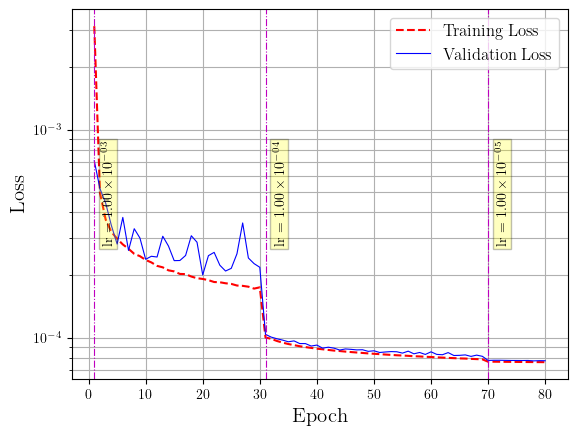

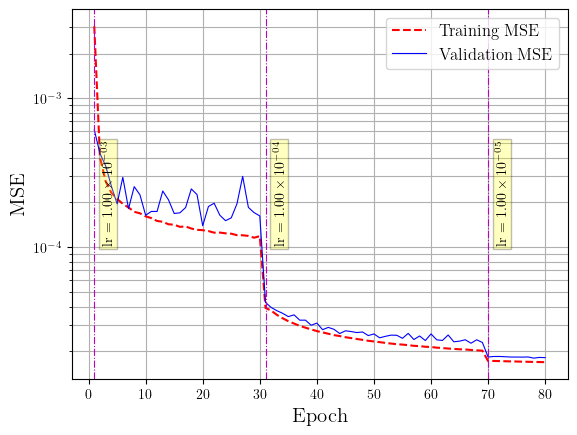

<Figure size 640x480 with 0 Axes>

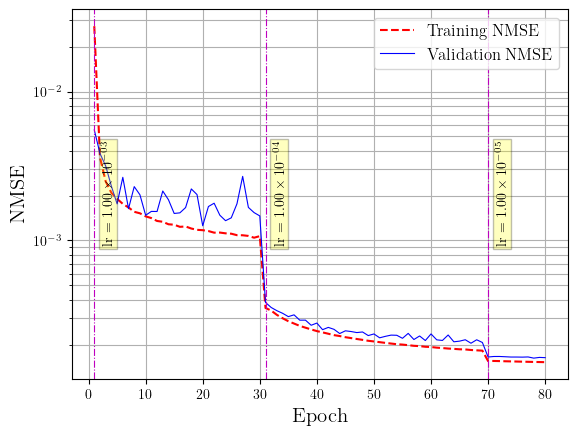

<Figure size 640x480 with 0 Axes>

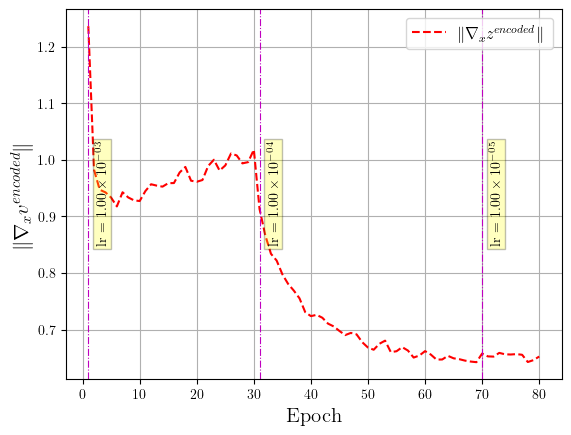

<Figure size 640x480 with 0 Axes>

In [39]:
# plotting losses
dir_name_plot = dir_name_ae + '/plots'
if not os.path.isdir(dir_name_plot):
    os.makedirs(dir_name_plot)

xlabel_kwargs = {"fontsize":15}
ylabel_kwargs = {"fontsize":15}
legend_kwargs = {"fontsize":12}
    
# Visualize loss history
fig, ax = plot_losses(
    training_loss=train_loss_hist,
    val_loss=val_loss_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list,
    xlabel_kwargs=xlabel_kwargs,
    ylabel_kwargs=ylabel_kwargs,
    legend_kwargs=legend_kwargs,
)

plt.savefig(dir_name_plot + '{ds}loss_history.pdf'.format(ds=dir_sep), dpi=300, bbox_inches='tight')
plt.show()


fig, ax = plot_losses(
    training_loss=train_MSE_hist,
    val_loss=val_MSE_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list,
    legend_list=['Training MSE', 'Validation MSE'],
    xlabel='Epoch',
    ylabel='MSE',
    xlabel_kwargs=xlabel_kwargs,
    ylabel_kwargs=ylabel_kwargs,
    legend_kwargs=legend_kwargs,
    
)
plt.savefig(dir_name_plot+'/MSE_history.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.clf()


fig, ax = plot_losses(
    training_loss=train_NMSE_hist,
    val_loss=val_NMSE_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list,
    legend_list=['Training NMSE', 'Validation NMSE'],
    xlabel='Epoch',
    ylabel='NMSE',
    xlabel_kwargs=xlabel_kwargs,
    ylabel_kwargs=ylabel_kwargs,
    legend_kwargs=legend_kwargs,
)
plt.savefig(dir_name_plot+'/NMSE_history.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.clf()


fig, ax = plot_losses(
    training_loss=train_ls_jacobian_norm_hist,
    val_loss=None,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list,
    legend_list=[r"$\| \nabla_{x} z^{encoded} \|$"],
    xlabel='Epoch',
    ylabel=r"$\| \nabla_{x} v^{encoded} \|$",
    plot_type='plot',
    xlabel_kwargs=xlabel_kwargs,
    ylabel_kwargs=ylabel_kwargs,
    legend_kwargs=legend_kwargs,
)
plt.savefig(dir_name_plot+'/train_ls_jacobian_norm_hist.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.clf()

In [40]:
reconstructed_data = ae_net.predict(all_data)

In [41]:
temp = boundary_idx_arr[0] + np.sum(boundary_idx_arr[1:] - boundary_idx_arr[0:-1])
temp /= len(boundary_idx_arr)
temp *= dt_ae
chosen_interval = temp//10
sn = np.format_float_scientific(chosen_interval, exp_digits=4)
snap = np.max([0.1, 25*np.round(10*float(sn[0:-6])/25)/10])
snap *= float('1'+sn[-6:])
xticks_snapto = int(snap*np.round(chosen_interval/snap))

plot_reconstructed_data_KS(
    boundary_idx_arr,
    dir_name_ae,
    all_data,
    reconstructed_data, dt_ae, xgrid,
    save_figs=True,
    normalization_constant_arr=normalization_constant_arr_aedata,
    xticks_snapto=xticks_snapto,
    num_yticks=11)

In [42]:
# create data
latent_states_all = ae_net.encoder_net.predict(all_data)

In [43]:
plot_latent_states_KS(
    boundary_idx_arr,
    latent_states_all,
    dt_ae,
    dir_name_ae,
    xticks_snapto=xticks_snapto,
    num_yticks=11,
    save_figs=True)

In [44]:
# fig.savefig(dir_name_plot+'/latent_states.png', dpi=300, bbox_inches='tight')

In [45]:
# ae_net.summary()

In [46]:
n = len(boundary_idx_arr)
num_digits_n = int(np.log10(n)+1)

# '''
num_cols = 4
num_rows = (latent_states_all.shape[-1] + num_cols-1)//num_cols
factor = 1
num_modes = xgrid.shape[0]

prev_idx = 0
for i in range(n):
    lyap_time = lyapunov_time_arr[i]
    start_time = 0
    plot_time = 20*lyap_time
    # next_idx = boundary_idx_arr[i]
    prev_idx += int((start_time + 0.5*dt_ae)//dt_ae) 
    next_idx = prev_idx + int((plot_time+0.5*dt_ae)//dt_ae)
    fig, ax = plt.subplots(num_rows, num_cols, sharex=False, figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
    N = next_idx - prev_idx
    # print(N)
    input_time = (start_time + np.arange(0, N)*dt_ae)/lyap_time
    
    # temp = N*delta_t
    # chosen_interval = temp//10
    # sn = np.format_float_scientific(chosen_interval, exp_digits=4)
    # # print(temp, sn)
    # snap = 25*np.round(10*float(sn[0:-6])/25)/10
    # if snap == 0:
    #     snap = 0.1
    # snap *= float('1'+sn[-6:])
    # xticks_snapto = int(snap*np.round(chosen_interval/snap))

    for j in range(latent_states_all.shape[-1]):
        row = j // num_cols
        col = j % num_cols
        ax[row, col].plot(input_time, latent_states_all[prev_idx:next_idx, j])
        # ax[j].plot(input_time, D_reconstructed_list[i][prev_idx:next_idx], color='C0', label='Reconstructed Data')
        # num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
        # xticks = int((start_time + 0.5*delta_t)//delta_t) + np.arange(0, N+1, int((xticks_snapto+0.5*delta_t)//delta_t))
        # print(xticks)
        # ax[j].set_xticks(ticks=np.round(xticks*delta_t, 1))
        # ax[j].set_xticklabels('')
        ax[row, col].tick_params(axis='x', rotation=270+45)
        ax[row, col].set_ylabel('latent state {}'.format(j+1))
        ax[row, col].set_xlabel(r'Time$^+$')
        ax[row, col].grid(True)

    # yticks = np.linspace(0, 1, 10+1)*(len(xgrid)-1)
    # yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
    # ax.set_yticks(ticks=yticks)
    # ax.set_yticklabels(yticklabels)

    # ax[-1].set_xlabel(r'Time$^+$')
    # ax[0].legend()
    # ax.title.set_text(r'Latent States')
    # if ax_titles_list is not None:
    #     ax.title.set_text(ax_titles_list[i])
    # else:
    # ax.title.set_text(r'Case '+str(i+1))

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.suptitle('Case '+str(i+1), size=16)
    
    fig.savefig(dir_name_plot+'/LatentSpace-Case_'+str(i+1).zfill(num_digits_n)+'.pdf', dpi=300, bbox_inches='tight')
    fig.clear()
    plt.close()
    
    print('')

    prev_idx = boundary_idx_arr[i]

# KE and Dissipation

In [47]:
save_dir = dir_name_ae+dir_sep+'plots'
# save_dir = None

In [48]:
# Time evolution of Kinetic Energy
KE_org_list = []
KE_reconstructed_list = []
KE_nrmse = []

if normalizeforae_flag == True:
    rescaled_org_data = all_data[:, 0:xgrid.shape[0]]#.copy()
    rescaled_recon_data = reconstructed_data[:, 0:xgrid.shape[0]]#.copy()
    for i in range(xgrid.shape[0]):
        rescaled_org_data[:, i] *= normalization_constant_arr_aedata[1, i]
        rescaled_org_data[:, i] += normalization_constant_arr_aedata[0, i]
        rescaled_recon_data[:, i] *= normalization_constant_arr_aedata[1, i]
        rescaled_recon_data[:, i] += normalization_constant_arr_aedata[0, i]
else:
    rescaled_org_data = all_data[:, 0:xgrid.shape[0]]
    rescaled_recon_data = reconstructed_data[:, 0:xgrid.shape[0]]

if normalize_flag_ogdata == True:
    for i in range(xgrid.shape[0]):
        rescaled_org_data[:, i] *= normalization_constant_arr_ogdata[1, i]
        rescaled_org_data[:, i] += normalization_constant_arr_ogdata[0, i]
        rescaled_recon_data[:, i] *= normalization_constant_arr_ogdata[1, i]
        rescaled_recon_data[:, i] += normalization_constant_arr_ogdata[0, i]

begin_idx = 0
for i in range(len(boundary_idx_arr)):
    KE_org = np.sum(rescaled_org_data[begin_idx:boundary_idx_arr[i], 1:-1]**2, axis=1)
    KE_org += 0.5*(rescaled_org_data[begin_idx:boundary_idx_arr[i], 0]**2)
    KE_org += 0.5*(rescaled_org_data[begin_idx:boundary_idx_arr[i], -1]**2)
    KE_org /= xgrid.shape[0]-1
    KE_org_list.append(KE_org)
    
    KE_recon = np.sum(rescaled_recon_data[begin_idx:boundary_idx_arr[i], 1:-1]**2, axis=1)
    KE_recon += 0.5*(rescaled_recon_data[begin_idx:boundary_idx_arr[i], 0]**2)
    KE_recon += 0.5*(rescaled_recon_data[begin_idx:boundary_idx_arr[i], -1]**2)
    KE_recon /= xgrid.shape[0]-1
    KE_reconstructed_list.append(KE_recon)

    KE_rmse = np.mean((KE_recon - KE_org)**2)**0.5
    KE_mean = np.mean(KE_org)
    KE_rmse_normalized = KE_rmse/KE_mean
    KE_nrmse.append(KE_rmse_normalized)
    
    print('Case {} - KE_nrmse : {}'.format(i+1, KE_rmse_normalized))

    begin_idx = boundary_idx_arr[i]

Case 1 - KE_nrmse : 0.006208904398079401


In [49]:
n = len(boundary_idx_arr)
num_digits_n = int(np.log10(n)+1)

# '''
num_cols = 1
num_rows = 1
factor = 1

num_modes = xgrid.shape[0]

prev_idx = 0
for i in range(n):
    lyap_time = lyapunov_time_arr[i]
    print(lyap_time)
    start_time = 0
    plot_time = 20*lyap_time
    # next_idx = boundary_idx_arr[i]
    prev_idx += int((start_time + 0.5*dt_ae)//dt_ae) 
    next_idx = prev_idx + int((plot_time+0.5*dt_ae)//dt_ae)
    fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
    N = next_idx - prev_idx
    # print(N)
    input_time = (start_time + np.arange(0, N)*dt_ae)/lyap_time

    # temp = N*delta_t
    # chosen_interval = temp//10
    # sn = np.format_float_scientific(chosen_interval, exp_digits=4)
    # # print(temp, sn)
    # snap = 25*np.round(10*float(sn[0:-6])/25)/10
    # if snap == 0:
    #     snap = 0.1
    # snap *= float('1'+sn[-6:])
    # xticks_snapto = int(snap*np.round(chosen_interval/snap))

    # prev_idx = boundary_idx_arr[i] - (next_idx-prev_idx)
    # next_idx = boundary_idx_arr[i]
    
    ax.plot(input_time, KE_org_list[i][prev_idx:next_idx], color='k', label='Original Data')
    ax.plot(input_time, KE_reconstructed_list[i][prev_idx:next_idx], color='C0', label='Reconstructed Data')
    # num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
    # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
    # xticks = int((start_time + 0.5*delta_t)//delta_t) + np.arange(0, N+1, int((xticks_snapto+0.5*delta_t)//delta_t))
    # print(xticks)
    # ax.set_xticks(ticks=np.round(xticks*delta_t, 1))
    # ax.set_xticklabels(np.round(xticks*delta_t, 1))
    ax.tick_params(axis='x', rotation=270+45)

    # yticks = np.linspace(0, 1, 10+1)*(len(xgrid)-1)
    # yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
    # ax.set_yticks(ticks=yticks)
    # ax.set_yticklabels(yticklabels)

    ax.set_xlabel(r'Time$^+$', fontsize=15)
    ax.set_ylabel(r'$KE$', fontsize=15)
    ax.grid(True)
    ax.legend(fontsize=12)
    # ax.title.set_text(r'Latent States')
    # if ax_titles_list is not None:
    # ax.title.set_text(ax_titles_list[i])
    # else:
    ax.title.set_text(r'Case '+str(i+1))

    text_xy = [0.05, 0.05]
    ax.text(
        text_xy[0],
        text_xy[1],
        'latent space dimensions : {}'.format(
            latent_states_all.shape[1],
        ),
        transform=ax.transAxes,
        bbox=dict(
            boxstyle="round",
            ec=(0.6, 0.6, 1),
            fc=(0.9, 0.9, 1),
            alpha=0.8
        ),
        # bbox=dict(facecolor='C0', alpha=0.5, boxstyle='round,pad=0.2'),
        horizontalalignment='left',
        verticalalignment='bottom'
    )
    
    # plt.colorbar(im)
    if save_dir is not None:
        fig.savefig(save_dir+dir_sep+'KE-Case_'+str(i+1).zfill(num_digits_n)+'.pdf', dpi=300, bbox_inches='tight')
        fig.clear()
        plt.close()
    else:
        plt.show()
        print('')

    prev_idx = next_idx

15.466301


In [50]:
def compute_laplace_operator(
        data,
        xgrid
    ):
    from scipy.fft import fft, ifft, fftfreq
    M = xgrid.shape[0]
    length = xgrid[-1]
    k = fftfreq(M) * M * 2*np.pi/length
    laplace_operated_data = data[:, 0:M].copy()
    for i in range(data.shape[0]):
        v = fft(data[i, 0:M])
        v = k*k*v
        laplace_operated_data[i, :] = np.real(ifft(v))
    return laplace_operated_data

In [51]:
# Time evolution of Dissipation
D_org_list = []
D_reconstructed_list = []
D_nrmse = []

begin_idx = 0
for i in range(len(boundary_idx_arr)):
    temp = compute_laplace_operator(rescaled_org_data[begin_idx:boundary_idx_arr[i]], xgrid)
    D_org = np.sum(temp[:, 1:-1]**2, axis=1)
    D_org += 0.5*(temp[:, 0]**2)
    D_org += 0.5*(temp[:, -1]**2)
    D_org /= xgrid.shape[0]-1
    D_org_list.append(D_org)
    
    temp = compute_laplace_operator(rescaled_recon_data[begin_idx:boundary_idx_arr[i]], xgrid)
    D_recon = np.sum(temp[:, 1:-1]**2, axis=1)
    D_recon += 0.5*(temp[:, 0]**2)
    D_recon += 0.5*(temp[:, -1]**2)
    D_recon /= xgrid.shape[0]-1
    D_reconstructed_list.append(D_recon)
    
    D_rmse = np.mean((D_recon - D_org)**2)**0.5
    D_mean = np.mean(D_org)
    D_rmse_normalized = D_rmse/D_mean
    D_nrmse.append(D_rmse_normalized)
    
    print('Case {} - D_nrmse : {}'.format(i+1, D_rmse_normalized))
    
    begin_idx = boundary_idx_arr[i]

Case 1 - D_nrmse : 0.013530925521661966


In [52]:
n = len(boundary_idx_arr)
num_digits_n = int(np.log10(n)+1)

# '''
num_cols = 1
num_rows = 1
factor = 1
num_modes = xgrid.shape[0]

prev_idx = 0
for i in range(n):
    lyap_time = lyapunov_time_arr[i]
    start_time = 0
    plot_time = 20*lyap_time
    # next_idx = boundary_idx_arr[i]
    prev_idx += int((start_time + 0.5*dt_ae)//dt_ae) 
    next_idx = prev_idx + int((plot_time+0.5*dt_ae)//dt_ae)
    fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
    N = next_idx - prev_idx
    # print(N)
    input_time = (start_time + np.arange(0, N)*dt_ae)/lyap_time
    
    # temp = N*delta_t
    # chosen_interval = temp//10
    # sn = np.format_float_scientific(chosen_interval, exp_digits=4)
    # # print(temp, sn)
    # snap = 25*np.round(10*float(sn[0:-6])/25)/10
    # if snap == 0:
    #     snap = 0.1
    # snap *= float('1'+sn[-6:])
    # xticks_snapto = int(snap*np.round(chosen_interval/snap))

    ax.plot(input_time, D_org_list[i][prev_idx:next_idx], color='k', label='Original Data')
    ax.plot(input_time, D_reconstructed_list[i][prev_idx:next_idx], color='C0', label='Reconstructed Data')
    # num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
    # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
    # xticks = int((start_time + 0.5*delta_t)//delta_t) + np.arange(0, N+1, int((xticks_snapto+0.5*delta_t)//delta_t))
    # print(xticks)
    # ax.set_xticks(ticks=np.round(xticks*delta_t, 1))
    # ax.set_xticklabels(np.round(xticks*delta_t, 1))
    ax.tick_params(axis='x', rotation=270+45)

    # yticks = np.linspace(0, 1, 10+1)*(len(xgrid)-1)
    # yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
    # ax.set_yticks(ticks=yticks)
    # ax.set_yticklabels(yticklabels)

    ax.set_xlabel(r'Time$^+$', fontsize=15)
    ax.set_ylabel(r'$D$', fontsize=15)
    ax.grid(True)
    ax.legend(fontsize=12)
    # ax.title.set_text(r'Latent States')
    # if ax_titles_list is not None:
    #     ax.title.set_text(ax_titles_list[i])
    # else:
    ax.title.set_text(r'Case '+str(i+1))

    text_xy = [0.05, 0.05]
    ax.text(
        text_xy[0],
        text_xy[1],
        'latent space dimensions : {}'.format(
            latent_states_all.shape[1],
        ),
        transform=ax.transAxes,
        bbox=dict(
            boxstyle="round",
            ec=(0.6, 0.6, 1),
            fc=(0.9, 0.9, 1),
            alpha=0.8
        ),
        # bbox=dict(facecolor='C0', alpha=0.5, boxstyle='round,pad=0.2'),
        horizontalalignment='left',
        verticalalignment='bottom'
    )

    if save_dir is not None:
        fig.savefig(save_dir+'/Dissipation-Case_'+str(i+1).zfill(num_digits_n)+'.pdf', dpi=300, bbox_inches='tight')
        fig.clear()
        plt.close()
    else:
        plt.show()
        print('')

    prev_idx = next_idx

In [53]:
np.savez(
    dir_name_ae+dir_sep+'KE_D_data',
    KE_org_list=KE_org_list,
    KE_reconstructed_list=KE_reconstructed_list,
    KE_nrmse=KE_nrmse,
    D_org_list=D_org_list,
    D_reconstructed_list=D_reconstructed_list,
    D_nrmse=D_nrmse,
    num_latent_states=[latent_states_all.shape[1]],
)

In [54]:
KE_D_data_dict = {
    'KE_org_list':list(KE_org_list),
    'KE_reconstructed_list':list(KE_reconstructed_list),
    'KE_nrmse':list(KE_nrmse),
    'D_org_list':list(D_org_list),
    'D_reconstructed_list':list(D_reconstructed_list),
    'D_nrmse':list(D_nrmse),
    'num_latent_states':[latent_states_all.shape[1]],
}

with open(dir_name_ae+'/KE_D_data.txt', 'w') as f:
    f.write(str(KE_D_data_dict))

In [55]:
if ae_net.use_weights_post_dense == True:
    print(ae_net.decoder_layers_list[-1].individual_weights)

<tf.Variable 'single_weights/individual_weights:0' shape=(64,) dtype=float32, numpy=
array([1.617769 , 1.62911  , 1.6094475, 1.5938883, 1.6272898, 1.6233637,
       1.6208405, 1.6441894, 1.6535528, 1.6345335, 1.6411684, 1.6286597,
       1.6395193, 1.5883584, 1.606947 , 1.6343619, 1.6416594, 1.6286874,
       1.6234268, 1.6267842, 1.6159458, 1.6256701, 1.6158617, 1.6219227,
       1.6093265, 1.6127965, 1.6269363, 1.622087 , 1.6190323, 1.6240621,
       1.6429893, 1.6322551, 1.6293505, 1.6249195, 1.6163832, 1.6199944,
       1.6375563, 1.6299268, 1.6301781, 1.6344227, 1.6258421, 1.6074839,
       1.602642 , 1.6129494, 1.6116407, 1.6273737, 1.6247654, 1.6173135,
       1.6114882, 1.6264495, 1.6310568, 1.6394905, 1.6262425, 1.6355271,
       1.6304691, 1.6450975, 1.6267034, 1.6271746, 1.6311859, 1.6045812,
       1.6125096, 1.6038665, 1.6276083, 1.6098382], dtype=float32)>


In [56]:
plt.close("all")